In [1]:
import numpy as np
from scipy.optimize import minimize, brute
import scipy
from scipy.linalg import solve_continuous_lyapunov
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
from scipy.io import loadmat
import os
np.set_printoptions(precision=3)
from itertools import groupby
from inference import * 
from utils import *

In [2]:
def convert_params(params): 
    J = np.array([[-params[0], params[2]], [-params[3], -params[1]]])
    B = np.diagflat(params[4:6])**2 
    c = params[3]/params[0] 
    B[1, 1] += c*c*B[0, 0] 
    B[1, 0] = c*B[0, 0]
    B[0, 1] = B[1, 0] 
    return J, B 

### First, we make some simulations with known parameters and infer them with both inference methods

In [26]:
# params in order of [epsilon, gamma-mu*c, mu, c]
T = 5e2
dt = 5e-3
n_frames = int(1*T) 
n_repeats = 5

params = [0.057, 2.51, 0.173, 1, 0.025, 0.787] 
J, B = convert_params(params)
print(J)
print(B)
print(np.linalg.eigvals(J))

m = sim(params, convert_params)
results = m.evolve(T, dt, n_frames, n_repeats)

[[-0.057  0.173]
 [-1.    -2.51 ]]
[[6.250e-04 1.096e-02]
 [1.096e-02 8.117e-01]]
[-0.13  -2.437]


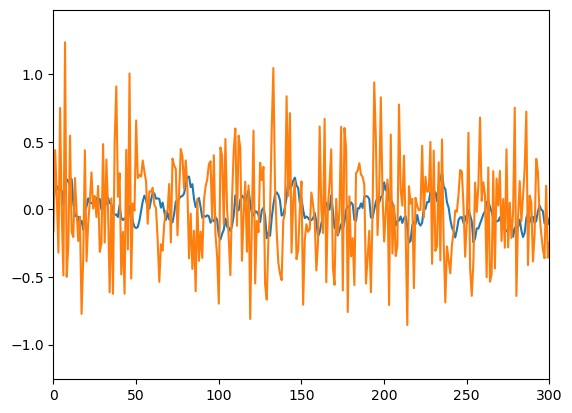

[array([0.002, 0.001]), array([-0.032, -0.005]), array([0.079, 0.016]), array([-0.029, -0.019]), array([-0.035,  0.024])]


In [27]:
plt.plot(results[0][0])
plt.plot(results[0][1])
plt.xlim([0, 300])
plt.show()

mean = lambda x: np.mean(x, axis=1)
print(list(map(mean, results)))

In [28]:
## Exact inference without constraints

inf = exact_inference(convert_params) 
inf.inf(results, 1)

(array([[-0.045,  0.179],
        [-1.121, -2.759]]),
 array([[4.978e-04, 1.337e-02],
        [1.337e-02, 8.702e-01]]))

In [30]:
## Numerical inference with constraints 

inf = inference(convert_params)
guess = [1, 1, 1, 1, 1, 1]
MAP, cost = inf.inf(guess, results, 1, brute_force=False)
print(MAP, cost)
print(params, inf._minuslogP(params, results, 1))

[0.045 2.729 0.178 1.117 0.023 0.729] -7470.671130747637
[0.057, 2.51, 0.173, 1, 0.025, 0.787] -7467.258028768778


In [3]:
# path = 'Data/N15_ThetaPola_DATA/' 
path = 'Data/N11_ThetaPola_DATA/'
files = [path + f for f in os.listdir(path) if f.endswith('mat')]
files.sort() # sort files so the polarization and theta are right next to each other in the list 

for element1, element2 in zip(files[::2], files[1::2]):
    print(f"{element1:} {element2:}")

theta_trajs = [] 
pol_trajs = []

for f in files: 
    if f.endswith('POLARIZATION.mat'):
        pol_trajs.append(loadmat(f)['POLA'])
    else: 
        theta_trajs.append(loadmat(f)['THETAd'])

Data/N11_ThetaPola_DATA/N11_1_R200_B30_04_05_POLARIZATION.mat Data/N11_ThetaPola_DATA/N11_1_R200_B30_04_05_ThetaTime.mat
Data/N11_ThetaPola_DATA/N11_1_R200_B50_04_05_POLARIZATION.mat Data/N11_ThetaPola_DATA/N11_1_R200_B50_04_05_ThetaTime.mat
Data/N11_ThetaPola_DATA/N11_1_R200_B50_25_04_POLARIZATION.mat Data/N11_ThetaPola_DATA/N11_1_R200_B50_25_04_ThetaTime.mat
Data/N11_ThetaPola_DATA/N11_1_R200_B50_26_04_POLARIZATION.mat Data/N11_ThetaPola_DATA/N11_1_R200_B50_26_04_ThetaTime.mat
Data/N11_ThetaPola_DATA/N11_2_R200_B50_26_04_POLARIZATION.mat Data/N11_ThetaPola_DATA/N11_2_R200_B50_26_04_ThetaTime.mat
Data/N11_ThetaPola_DATA/N11_3_R200_B50_25_04_POLARIZATION.mat Data/N11_ThetaPola_DATA/N11_3_R200_B50_25_04_ThetaTime.mat
Data/N11_ThetaPola_DATA/N11_4_R200_B100_25_04_POLARIZATION.mat Data/N11_ThetaPola_DATA/N11_4_R200_B100_25_04_ThetaTime.mat
Data/N11_ThetaPola_DATA/N11_4_R200_B30_25_04_POLARIZATION.mat Data/N11_ThetaPola_DATA/N11_4_R200_B30_25_04_ThetaTime.mat
Data/N11_ThetaPola_DATA/N11_4_

In [4]:
print(list(map(len, theta_trajs)))
print(list(map(len, pol_trajs)))

[print(theta[0, 0], p[0, 0]) for (theta, p) in zip(theta_trajs, pol_trajs) ];
is_finite = lambda p: np.isfinite(p[2])

del_list = [] 

for (i, (theta, p)) in enumerate(zip(theta_trajs, pol_trajs)): 
    if len(theta) != len(p) or np.any(np.isnan(p[:, 2])):
        del_list.append(i)
        
print(del_list)
for index in sorted(del_list, reverse=True):
    del theta_trajs[index]
    del pol_trajs[index]

[5000, 5000, 2450, 5000, 5000, 3000, 5000, 5000, 5000, 1300, 5000]
[5000, 5000, 2400, 5000, 5000, 3000, 5000, 5000, 5000, 1300, 5000]
0.03333333333333333 0.03333333333333333
0.03333333333333333 0.03333333333333333
0.03333333333333333 0.03333333333333333
0.03333333333333333 0.03333333333333333
0.03333333333333333 0.03333333333333333
0.03333333333333333 0.03333333333333333
0.03333333333333333 0.03333333333333333
0.03333333333333333 0.03333333333333333
0.03333333333333333 0.03333333333333333
0.03333333333333333 0.03333333333333333
0.03333333333333333 0.03333333333333333
[2]


In [8]:
print(list(map(np.shape, theta_trajs)))
print(list(map(np.shape, pol_trajs)))
dt = theta_trajs[0][0, 0]
print('dt = ', dt)

[(5000, 2), (5000, 2), (5000, 2), (5000, 2), (3000, 2), (5000, 2), (5000, 2), (5000, 2), (1300, 2), (5000, 2)]
[(5000, 4), (5000, 4), (5000, 4), (5000, 4), (3000, 4), (5000, 4), (5000, 4), (5000, 4), (1300, 4), (5000, 4)]
dt =  0.03333333333333333


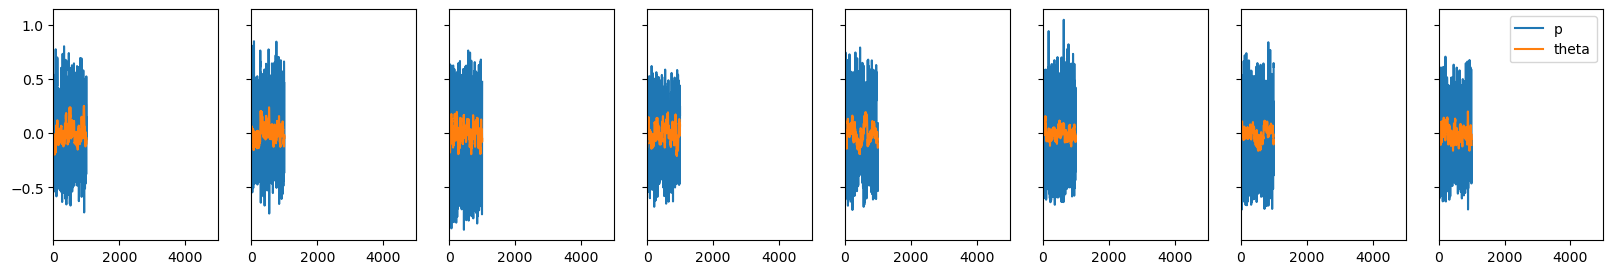

In [11]:
N = 5
f1 = lambda x: (x[:, 1])/180*np.pi - np.mean(x[:, 1])/180*np.pi
f2 = lambda x: np.mean(x[:, 1:4], axis=1) - np.mean(x[:, 1:4])
f3 = lambda x: x[:, 2] - np.mean(x[:, 2])
data = [np.stack([coarsen(f1(theta), N), coarsen(f3(p), N)]) for (theta, p) in zip(theta_trajs, pol_trajs)]
dt *= N 
show([d for d in data if len(d[0]) == 5000/N])

In [12]:
guess = [3, 0.1, 0.1, 1, 1, 1]
bounds = [[1e-10, None], [1e-10, None], [1e-10, None], [1e-10, None], [1e-10, None], [1e-10, None]]
inf = inference(convert_params)
MAP, y = inf.inf(guess, data, dt, bounds=bounds)
print(MAP, y)
print('gamma = ', MAP[1]+MAP[2]*MAP[3])

[0.019 0.388 0.035 0.072 0.012 0.287] -44423.2724247142
gamma =  0.3905226870494268


In [13]:
err, _ = inf.std_error(MAP, data, dt, delta=1e-4)
print(err)

[1.905e-03 1.217e-02 4.927e-04 9.126e-03 9.323e-05 2.510e-03]


In [14]:
J, B = convert_params(MAP)
print(J)
print(B) 
print(np.linalg.eigvals(J))

[[-0.019  0.035]
 [-0.072 -0.388]]
[[0.    0.001]
 [0.001 0.084]]
[-0.026 -0.381]


In [15]:
inf2 = exact_inference(convert_params) 
J2, B2 = inf2.inf(data, dt) 
print(J2)
print(B2)
print(np.linalg.eigvals(J2))

[[-0.018  0.035]
 [-0.736 -0.369]]
[[0.    0.   ]
 [0.    0.081]]
[-0.124 -0.264]


In [16]:
print(inf2._minuslogP(J, B, data, dt))
print(inf2._minuslogP(J2, B2, data, dt))

-44423.2724247142
-44531.19939631704


In [19]:
n_frames = int(5000/N)
m = sim(MAP, convert_params)
n_repeats = 8
sims = m.evolve(n_frames*dt, 5e-3, n_frames, n_repeats)

In [ ]:
show(sims)

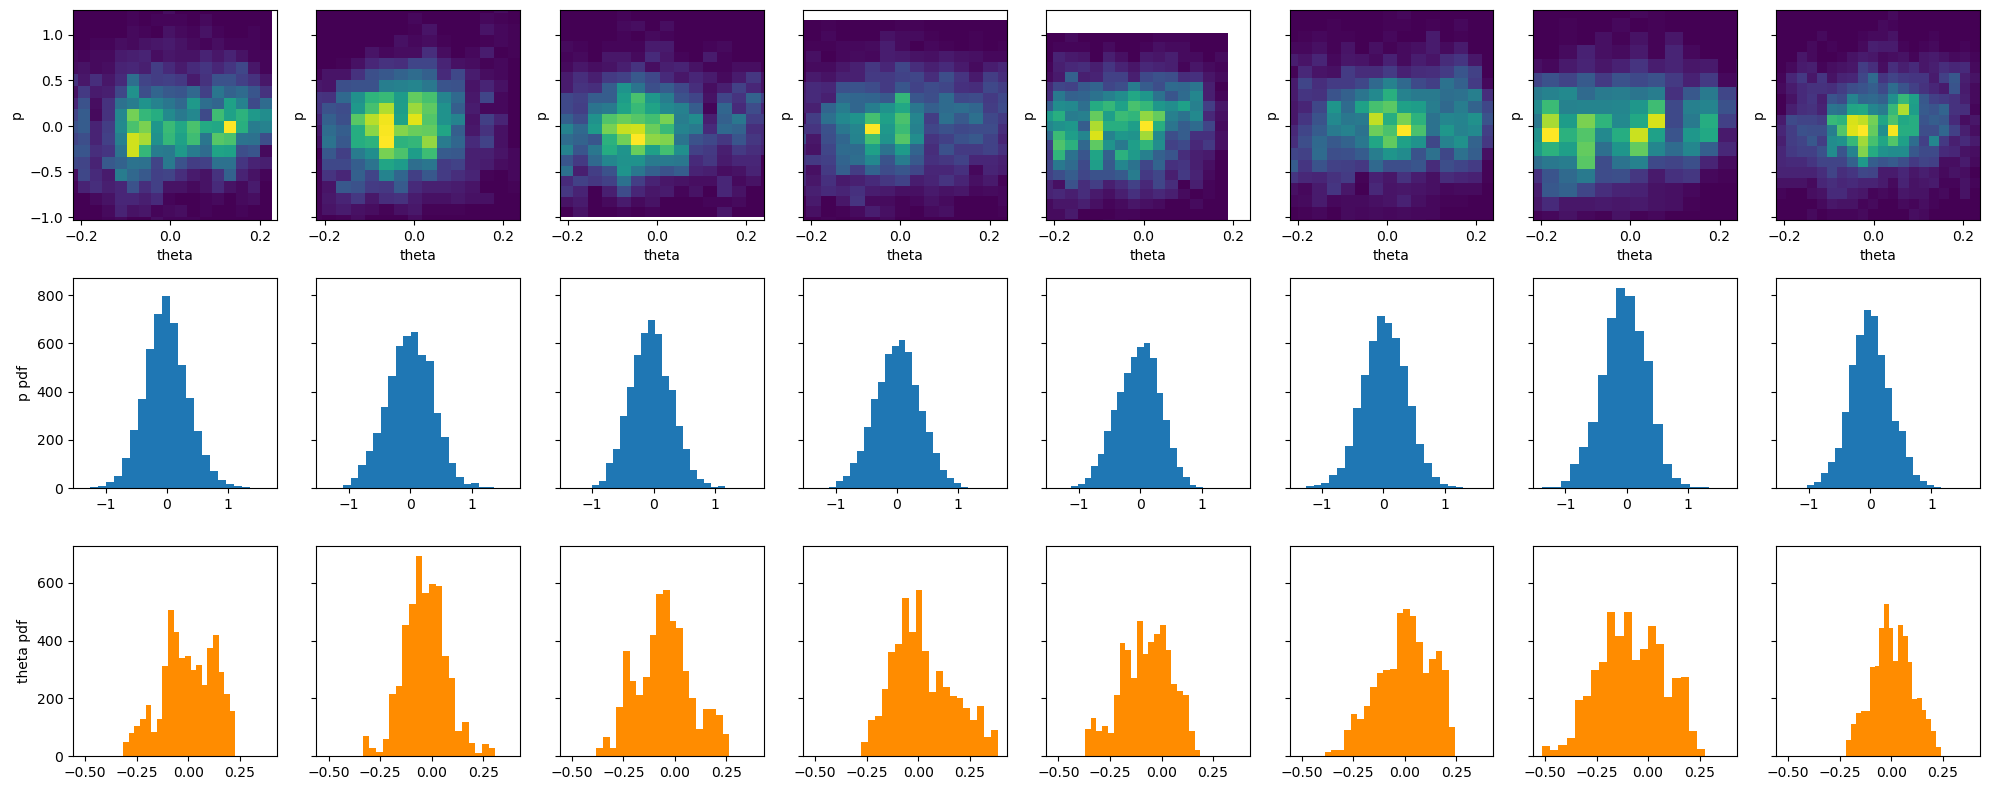

In [42]:
plot_dist(sims[:8])

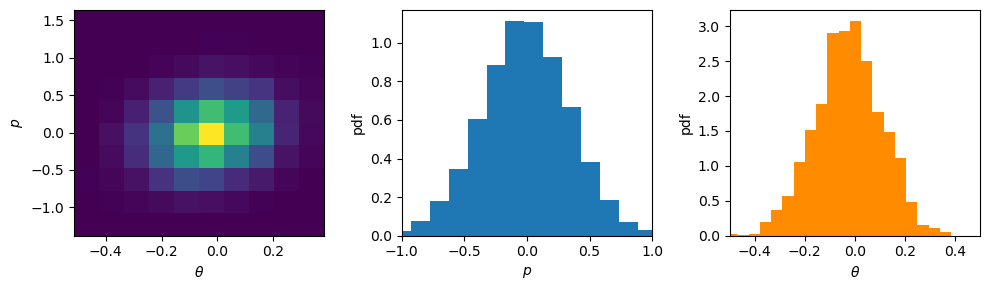

In [43]:
plot_overall_dist(sims)

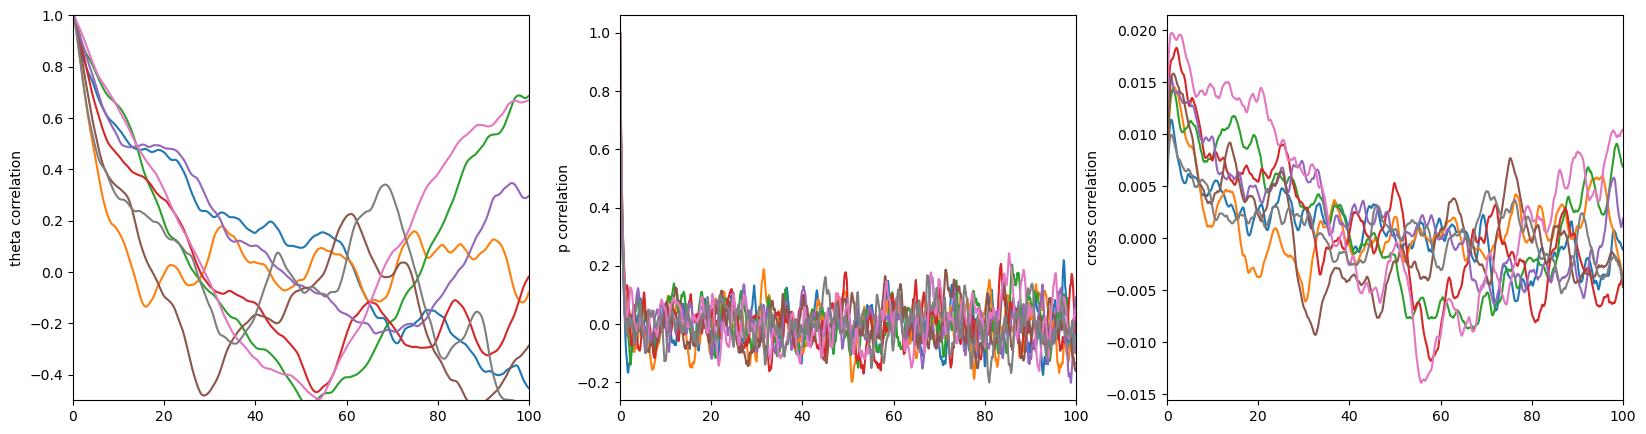

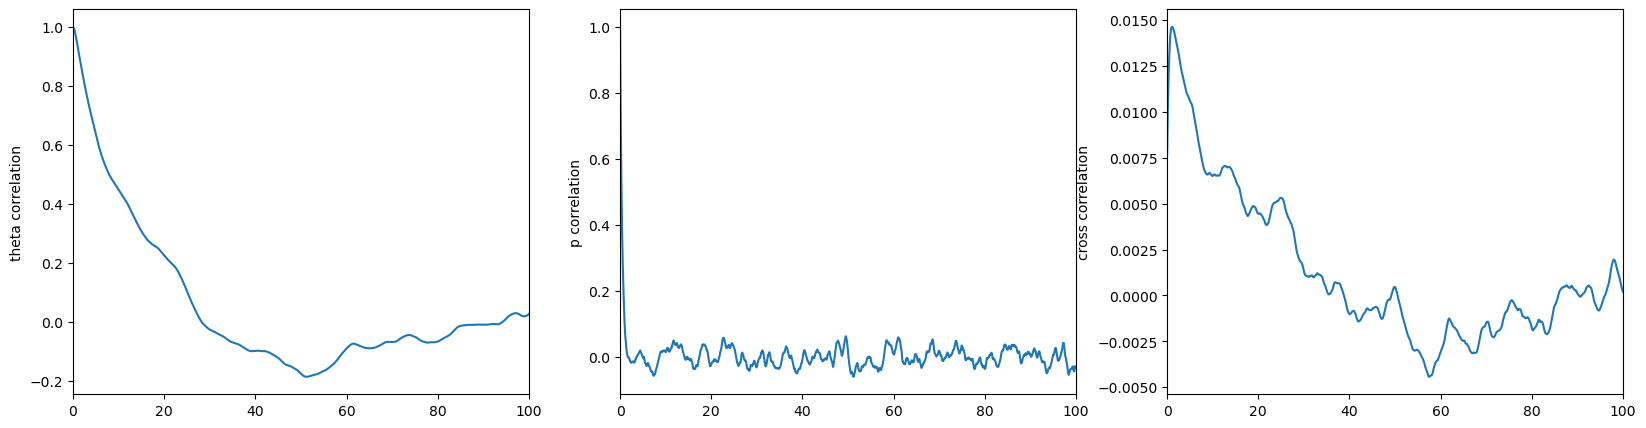

In [44]:
plot_corr(sims, 3000, dt); 

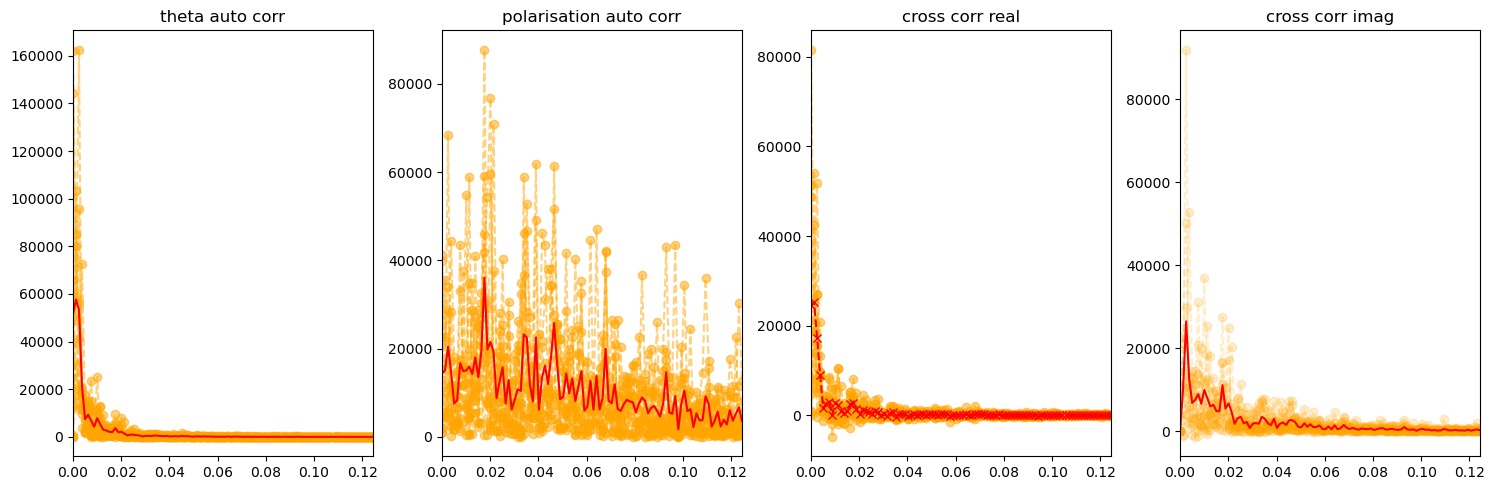

In [45]:
plot_corr_ft(np.array(sims), dt); 